In [143]:
#Import necessary libraries
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np

In [144]:
class CustomError(Exception):
    """Custom exception for handling specific errors."""
    def __init__(self, message="An error occurred"):
        self.message = message
        super().__init__(self.message)

In [145]:
def create_dataframe(filename):
    """ Takes Filename (1 arg) and returns a DataFrame with the relevant data."""
    time_data = []
    other_data = []
    with open('active_data/' + filename, 'r', encoding='utf-8') as f:
        for line in f:
                if "logprobs" in line:
                #Add relevant other data
                    pattern = re.compile(r"'finish_reason': '([^']*)|prompt_tokens': (\d*)|completion_tokens': (\d*)|total_tokens': (\d*)")
                #individually append all 4 groups, finish reason, prompt tokens, completion tokens, total tokens
                    for match in pattern.finditer(line):
                        count = 0
                        other_data.append(match.group(count))
                        count += 1
                elif "llama_perf_context_print" in line:
                #RE pattern for just grabbing numbers
                    pattern = r"\d+(?:\.\d+)?"
                #Adds timing data
                if "load time" in line:
                    matches = re.findall(pattern, line)
                    if len(matches) == 1:
                        time_data.append(float(matches[0]))  # Load Time
                    else:
                        CustomError("Unexpected number of matches for load time. Expected 1, got {}".format(len(matches)))
                elif "eval time" in line:
                    #!! Grabs both eval time and prompt eval time
                    matches = re.findall(pattern, line)
                    if len(matches) == 4:
                        time_data.append(float(matches[0])) 
                        time_data.append(int(matches[1]))
                        time_data.append(float(matches[2]))
                        time_data.append(float(matches[3]))
                    else:
                        CustomError("Unexpected number of matches for eval time. Expected 4, got {}".format(len(matches)))
                elif "total time" in line:
                    matches = re.findall(pattern, line)
                    if len(matches) == 2:
                        time_data.append(float(matches[0]))
                        time_data.append(float(matches[1]))
                    else:
                        CustomError("Unexpected number of matches for total time. Expected 1, got {}".format(len(matches)))


                    
    #Setting up and shaping time data
    num_experiments = len(time_data) // 11
    #if num_experiments != 25:
    #    CustomError("Some Time Based Data is Missing. Please check the file format or content.")
    time_data_reshaped = np.array(time_data).reshape(num_experiments, 11)
    df_main = pd.DataFrame(time_data_reshaped, columns=['Load Time', 'Prompt Eval Time (ms)', 'Prompt Eval Tokens', 'Prompt Eval Time Per Token (ms)', 'Prompt Eval Tokens Per Sec', 'Eval Time','Eval Tokens', 'Eval Time per token (ms)', 'Eval Tokens Per Sec', 'Total Time', 'Total Tokens (high)'])


    #Setting up and shaping other data
    
    #if num_experiments != 25:
    #    CustomError("Some Other Data is Missing. Please check the file format or content.")
    num_experiments = len(other_data) // 4
    other_data_reshaped = np.array(other_data).reshape(num_experiments, 4)
    df_other = pd.DataFrame(other_data_reshaped, columns=['Finish Reason', 'Prompt Tokens', 'Completion Tokens', 'Total Tokens (low)'])

    final_df = pd.concat([df_main, df_other], axis=1)
    #final_df['LLM'] = filename.split('.')[0]  # Extract LLM name from filename
    return final_df
    

In [146]:
def merge_dataframes():
    #Multi DataFrame Plotting
    dataframe_list = []
    for path in os.listdir('active_data'):
        df = create_dataframe(path)
        dataset_name = path.split('.txt')[0]
        # Add a new column to identify the dataset
        df["Dataset"] = dataset_name
        dataframe_list.append(df)
    my_dataframe = pd.concat(dataframe_list, ignore_index=True)
    return my_dataframe

In [147]:
#Gather Data Filenames from active data

os.listdir('active_data')

['gemma3-12b.txt',
 'gemma3-1b-stats.txt',
 'llama3.1-8b.txt',
 'llama3.2-1b.txt',
 'parsed_testing_output.txt']

<Axes: xlabel='Total Tokens (high)', ylabel='Total Time'>

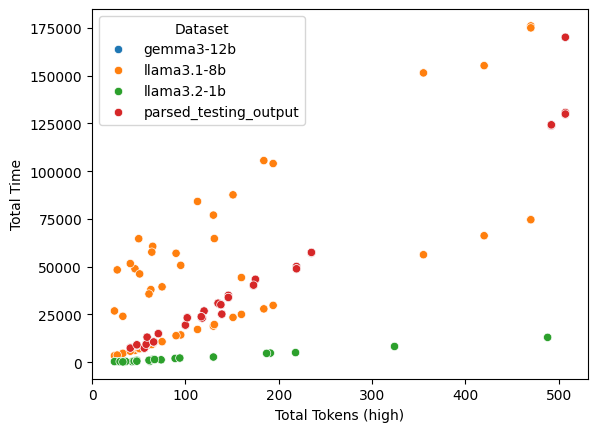

In [162]:
#my_dataframe = create_dataframe("gemma3-12b.txt")
#TODO: Impliment support for multiple datasets


combined_dataframe = merge_dataframes()
combined_dataframe
#sns.scatterplot(data=my_dataframe, x='Prompt Eval Tokens', y='Eval Tokens', hue='Finish Reason')
#sns.scatterplot(data=my_dataframe, x='Total Time', y='Total Tokens (high)', hue='Finish Reason')
#
sns.scatterplot(data=combined_dataframe, x='Total Tokens (high)', y='Total Time', hue='Dataset')
#print(combined_dataframe.to_string())


<Axes: xlabel='Prompt Eval Tokens', ylabel='Prompt Eval Time (ms)'>

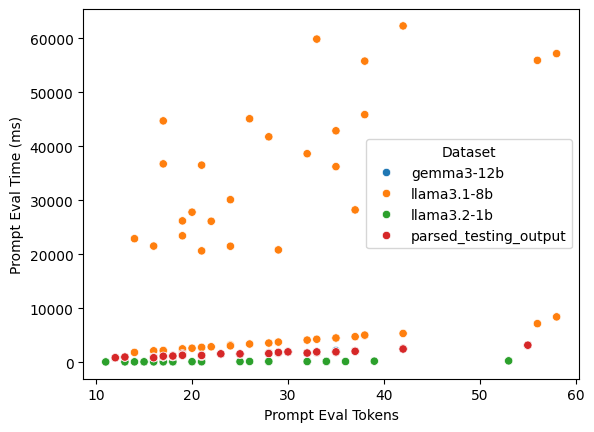

In [149]:
sns.scatterplot(data=combined_dataframe, x='Prompt Eval Tokens', y='Prompt Eval Time (ms)', hue='Dataset')


<Axes: xlabel='Eval Tokens', ylabel='Eval Time'>

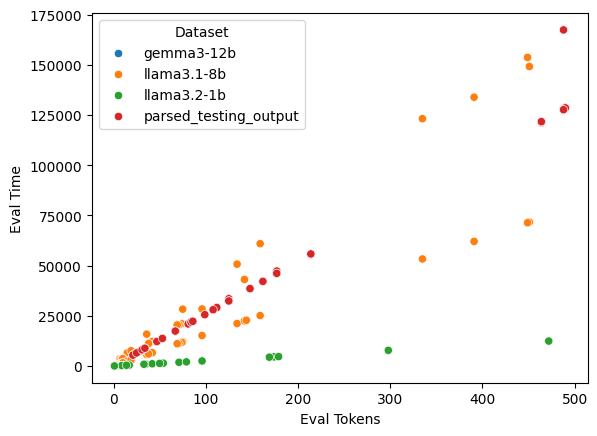

In [150]:
sns.scatterplot(data=combined_dataframe, x='Eval Tokens', y='Eval Time', hue='Dataset')


<Axes: xlabel='Eval Tokens', ylabel='Total Time'>

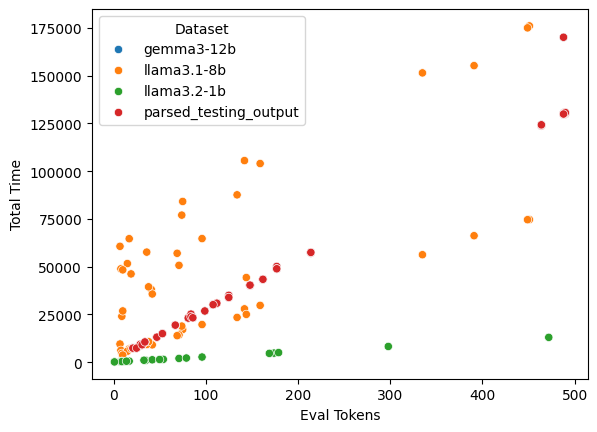

In [151]:
sns.scatterplot(data=combined_dataframe, x='Eval Tokens', y='Total Time', hue='Dataset')

<Axes: xlabel='Finish Reason', ylabel='count'>

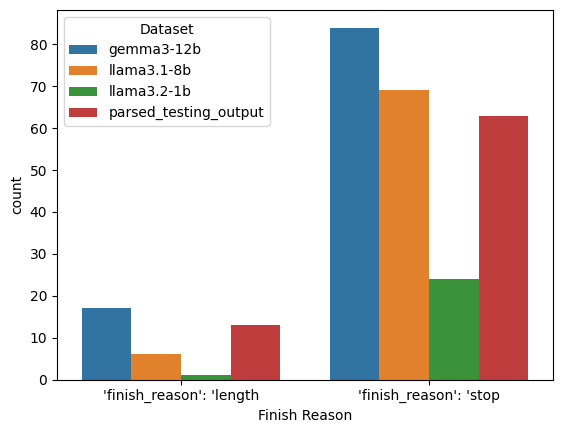

In [152]:
sns.countplot(data=combined_dataframe, x='Finish Reason', hue='Dataset')

([<matplotlib.patches.Wedge at 0x25c4c431730>,
 [Text(-1.004561496689549, 0.4481698331758321, "'finish_reason': 'stop"),
  Text(1.0045614290177756, -0.44816998486039294, "'finish_reason': 'length")],
 [Text(-0.5479426345579358, 0.24445627264136294, '86.6%'),
  Text(0.5479425976460593, -0.24445635537839613, '13.4%')])

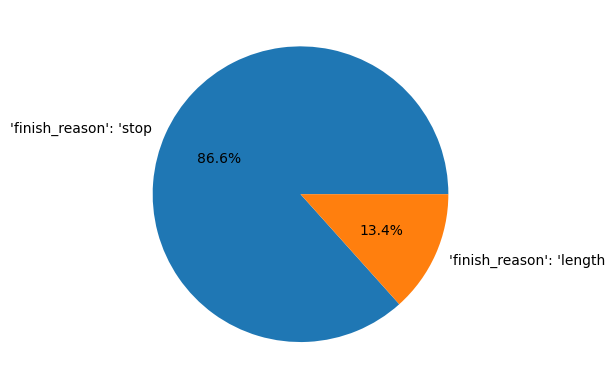

In [153]:
# This requires matplotlib.pyplot, usually imported as plt

plt.pie(combined_dataframe['Finish Reason'].value_counts(), labels=combined_dataframe['Finish Reason'].value_counts().index, autopct='%1.1f%%')


<Axes: xlabel='Total Time', ylabel='Count'>

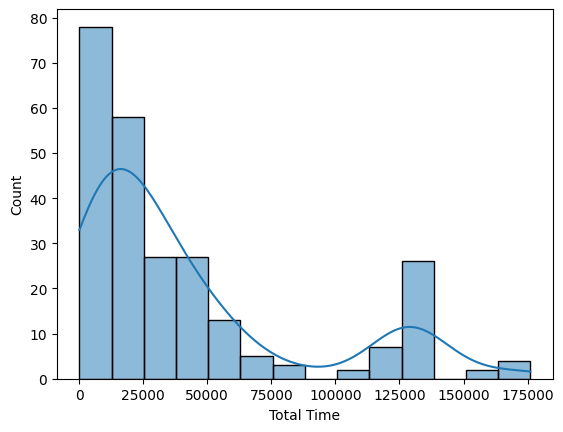

In [156]:
#sns.histplot(data=combined_dataframe, x='Total Time', kde=True, hue='Dataset')
sns.histplot(data=combined_dataframe, x='Total Time', kde=True)

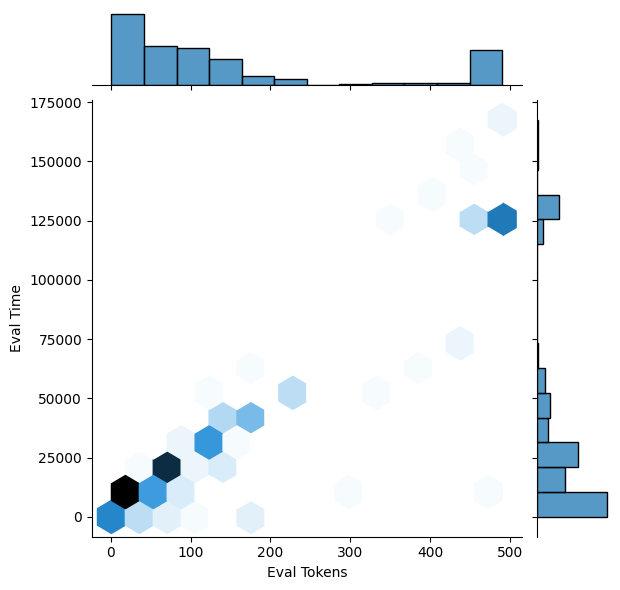

In [157]:
sns.jointplot(data=combined_dataframe, x='Eval Tokens', y='Eval Time', kind='hex')


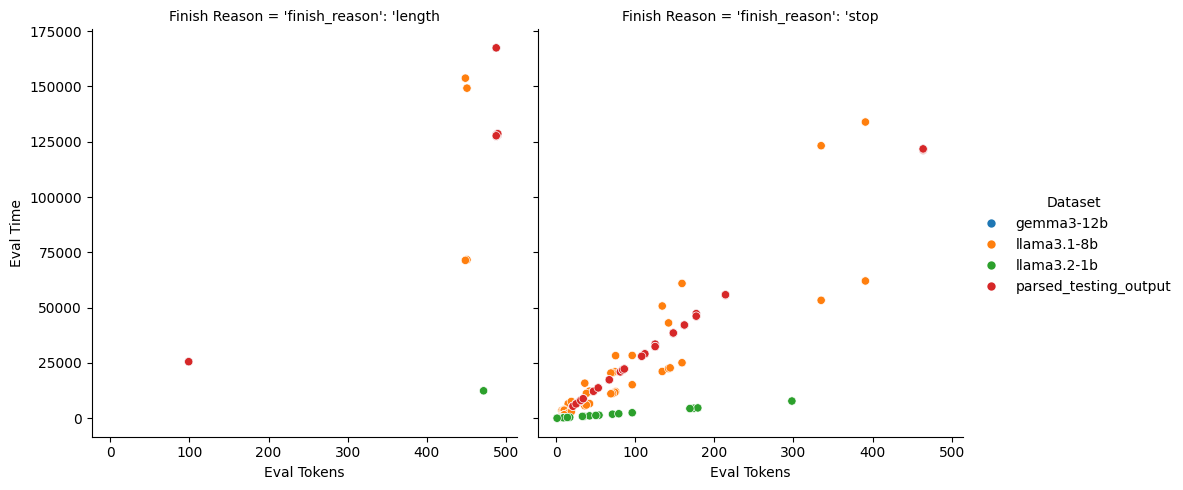

In [158]:
sns.relplot(data=combined_dataframe, x='Eval Tokens', y='Eval Time', col='Finish Reason', kind='scatter', hue='Dataset')

In [160]:
summary_stats = combined_dataframe.groupby('Dataset')['Total Time'].agg(['mean', 'median', 'std']).reset_index()

summary_stats

,Dataset,mean,median,std
0,gemma3-12b,45268.279604,25171.63,44921.889005
1,llama3.1-8b,48479.053600,38763.96,44224.413211
2,llama3.2-1b,2142.272800,1016.69,3024.518006
3,parsed_testing_output,45327.542895,25162.48,45233.669896
